<a href="https://colab.research.google.com/github/Prompt-Sopa/CODERHOUSE-NLP-DL/blob/main/TP_Coder_Alsop_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Final - CODERHOUSE

- Alumno: Agustin Alsop

##Actividad 2

- Considerando lo visto dentro de las clases de redes neuronales seleccionar un dataset de trabajo (puede ser nuevo o de los preparados para learning estilo MNIST).

- Cargar el dataset usando la función adecuada.

- Hacer una análisis exploratorio e identificar al menos tres insights sobre el mismo.

- Entrenar una red neuronal sencilla al menos dos capas (puede ser convolucional o recurrente).

- Plantear conclusiones.

##Extra

Como se opto desarrollar mas esta actividad se agrega lo siguiente

Para trabajo final si se opta por Deep Learning debe adicionarse alguna de las siguientes tareas:

- Adicionar al menos dos capas a la red para mejorar su rendimiento.

- Comparar los resultados contra el modelo sencillo. Dimensionar mejoras.

##Resolución

Para la realización de este trabajo se utilizó el set de datos de cifar10, la idea es entrenar una red neuronal que pueda diferenciar entre las distintas clases que se encuentran en el data set

In [1]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GaussianNoise, GaussianDropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from sklearn.datasets import make_moons

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
print(mpl.rcParams['figure.figsize'])

[12.0, 8.0]


100 primeros elementos del conjunto de entrenamiento


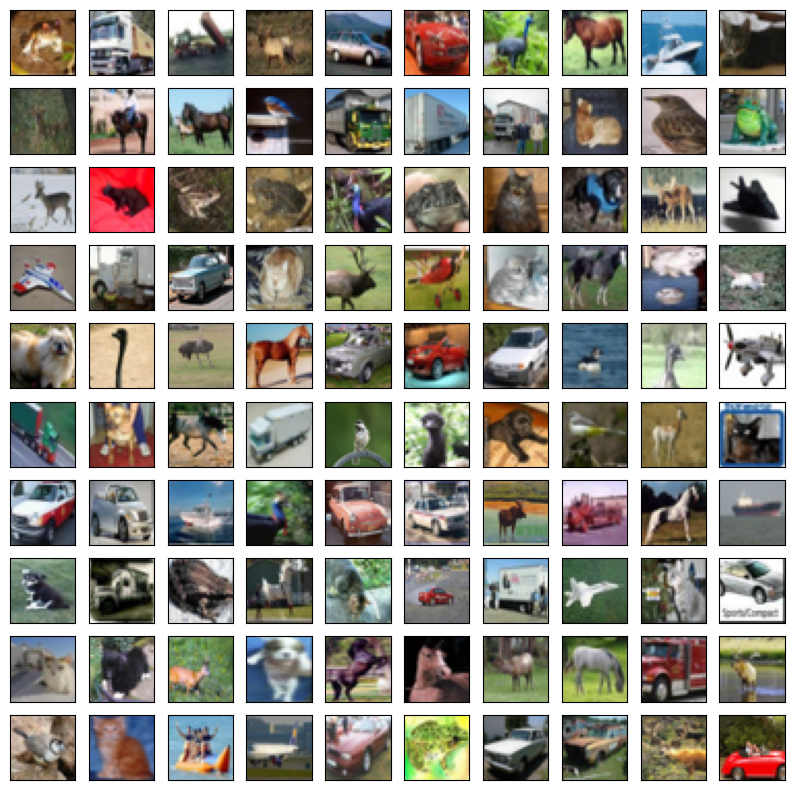

Forma de y_train: (50000, 10)
Forma de y_test: (10000, 10)


In [6]:
# Cargar datos
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Mostrar los primeros 100 elementos del dataset
print("100 primeros elementos del conjunto de entrenamiento")
f = plt.figure(figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax = f.add_subplot(10, 10, i + j*10 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(x_train[i + j*10])
plt.show()

# Normalización
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding de las etiquetas
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Verificar dimensiones
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

Observamos como el data set en total contiene 60mil imagenes de 32x32 pixeles, se puede encontrar mas informacion de la base de datos en [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

De las 60mil imagenes se utilizaron 50 mil para entrenamiento y 10 mil para prueba

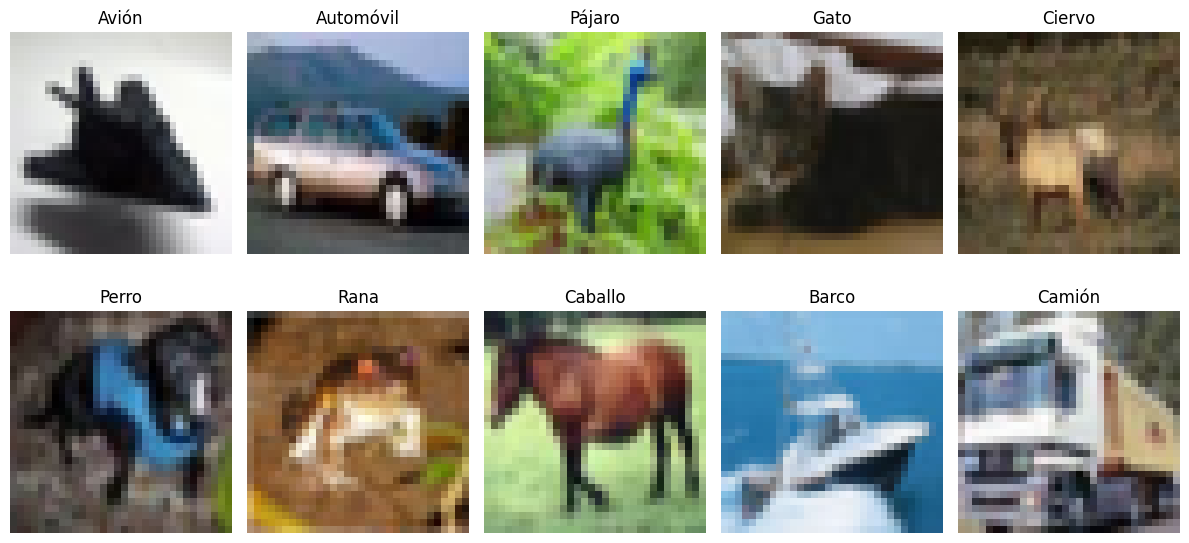

In [12]:
# Convertir de one-hot a valores enteros si es necesario
if y_train.ndim > 1 and y_train.shape[1] == 10:
    y_train_2 = np.argmax(y_train, axis=1)

# Etiquetas de CIFAR-10
class_names = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo",
               "Perro", "Rana", "Caballo", "Barco", "Camión"]

# Seleccionar una imagen por clase
unique_classes = np.unique(y_train_2)
images_per_class = {}

for img, label in zip(x_train, y_train_2.flatten()):
    if label not in images_per_class:
        images_per_class[label] = img
    if len(images_per_class) == 10:  # Tenemos todas las clases
        break

# Mostrar las imágenes
plt.figure(figsize=(12, 6))
for i, class_id in enumerate(unique_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_per_class[class_id])
    plt.title(class_names[class_id])
    plt.axis("off")

plt.tight_layout()
plt.show()

Podemos observar 10 clases en la base de datos compuestas por:
- Avión
- Automóvil
- Pájaro
- Gato
- Ciervo
- Perro
- Rana
- Caballo
- Barco
- Camión

De esta manera se puede ver la diferencias y complejidades de las imagenes, es un buen caso para estudiar como una red neuronal puede aprender para predecir de estas imagenes.

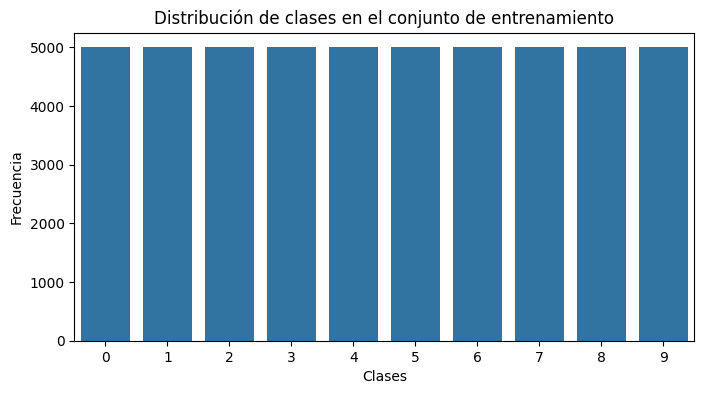

In [8]:
# Convertir de one-hot a valores enteros si es necesario
if y_train.ndim > 1 and y_train.shape[1] == 10:
    y_train_2 = np.argmax(y_train, axis=1)

# Contar frecuencia de clases
unique, counts = np.unique(y_train_2, return_counts=True)

# Graficar distribución de clases
plt.figure(figsize=(8,4))
sn.barplot(x=unique, y=counts)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xticks(range(10))
plt.show()


Se observa como el data set de entrenamiento esta totalmente balanceado por clase, teniendo 5 mil imagenes de cada clase

Media de los píxeles por canal (R, G, B): [0.4914009  0.48215896 0.4465308 ]
Desviación estándar de los píxeles por canal (R, G, B): [0.24703279 0.24348423 0.26158753]


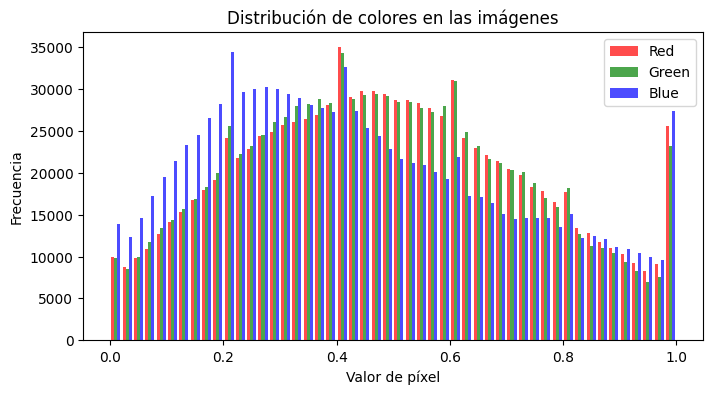

In [9]:
# Media y desviación estándar de los valores de los píxeles (por canal)
mean_pixel = np.mean(x_train, axis=(0,1,2))
std_pixel = np.std(x_train, axis=(0,1,2))
print("Media de los píxeles por canal (R, G, B):", mean_pixel)
print("Desviación estándar de los píxeles por canal (R, G, B):", std_pixel)

# Histograma de valores RGB
plt.figure(figsize=(8,4))
plt.hist(x_train[:1000].reshape(-1, 3), bins=50, color=['r','g','b'], alpha=0.7, label=['Red', 'Green', 'Blue'])
plt.xlabel("Valor de píxel")
plt.ylabel("Frecuencia")
plt.title("Distribución de colores en las imágenes")
plt.legend()
plt.show()


A modo de información tambien podemos observar que la media de las componentes RGB de las imagenes es similar tanto para Red, Green y Blue

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4047 - loss: 1.6973 - val_accuracy: 0.5496 - val_loss: 1.3083
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5765 - loss: 1.2269 - val_accuracy: 0.5887 - val_loss: 1.1790
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6209 - loss: 1.0958 - val_accuracy: 0.6026 - val_loss: 1.1447
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6501 - loss: 1.0116 - val_accuracy: 0.6241 - val_loss: 1.0779
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6777 - loss: 0.9318 - val_accuracy: 0.6247 - val_loss: 1.0863
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6921 - loss: 0.8871 - val_accuracy: 0.6361 - val_loss: 1.0362
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7113 - loss: 0.8467 - val_accuracy: 0.6290 - val_loss: 1.0712
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7231 - loss: 0.8109 - val_accuracy: 0.

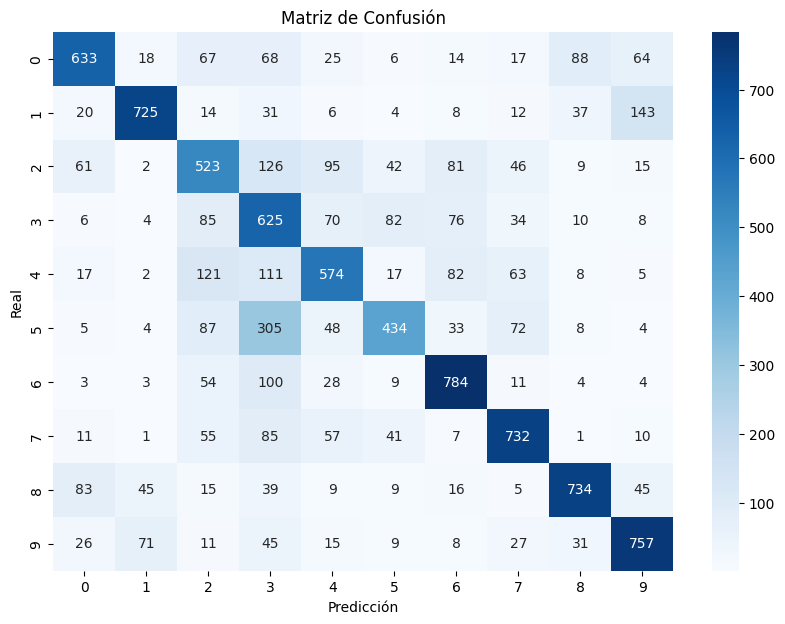

              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1000
           1       0.83      0.72      0.77      1000
           2       0.51      0.52      0.51      1000
           3       0.41      0.62      0.49      1000
           4       0.62      0.57      0.60      1000
           5       0.66      0.43      0.53      1000
           6       0.71      0.78      0.74      1000
           7       0.72      0.73      0.73      1000
           8       0.79      0.73      0.76      1000
           9       0.72      0.76      0.74      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.65     10000
weighted avg       0.67      0.65      0.65     10000



In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Definir modelo CNN con 2 capas convolucionales
model = Sequential([
    # Segunda capa convolucional con 64 filtros
    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D((2,2)),

    # Convertir los mapas de características en un vector
    Flatten(),

    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)  # Predicciones en formato de clase
y_test_labels = np.argmax(y_test, axis=1)  # Etiquetas reales en formato de clase

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3365 - loss: 1.8237 - val_accuracy: 0.5160 - val_loss: 1.3742
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5243 - loss: 1.3413 - val_accuracy: 0.5387 - val_loss: 1.2917
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5636 - loss: 1.2242 - val_accuracy: 0.5706 - val_loss: 1.2082
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5960 - loss: 1.1507 - val_accuracy: 0.5921 - val_loss: 1.1521
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6223 - loss: 1.0784 - val_accuracy: 0.6053 - val_loss: 1.1173
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6368 - loss: 1.0328 - val_accuracy: 0.5986 - val_loss: 1.1346
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6572 - loss: 0.9825 - val_accuracy: 0.6166 - val_loss: 1.0850
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6700 - loss: 0.9467 - val_accuracy: 0.

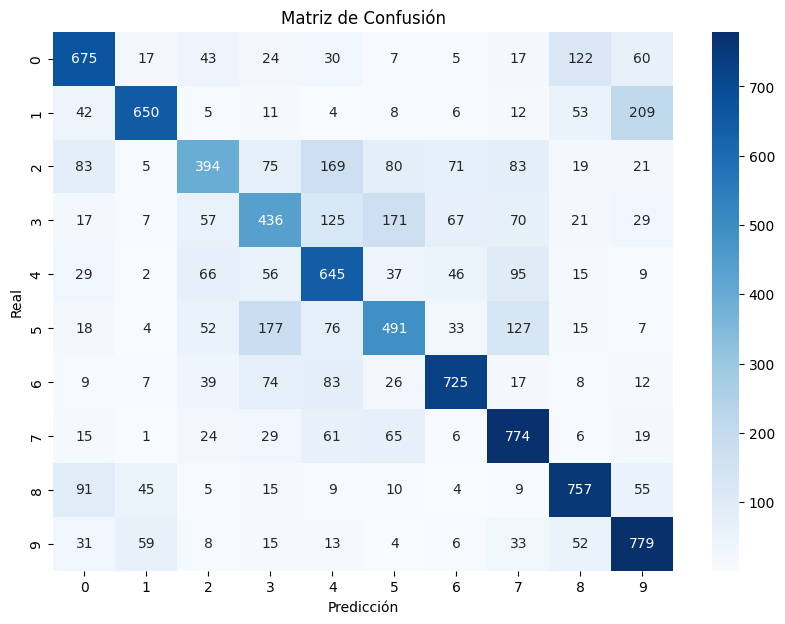

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1000
           1       0.82      0.65      0.72      1000
           2       0.57      0.39      0.47      1000
           3       0.48      0.44      0.46      1000
           4       0.53      0.65      0.58      1000
           5       0.55      0.49      0.52      1000
           6       0.75      0.72      0.74      1000
           7       0.63      0.77      0.69      1000
           8       0.71      0.76      0.73      1000
           9       0.65      0.78      0.71      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



In [13]:
# Definir modelo CNN con 2 capas convolucionales
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)  # Predicciones en formato de clase
y_test_labels = np.argmax(y_test, axis=1)  # Etiquetas reales en formato de clase

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

In [14]:
# Definir modelo CNN con 2 capas convolucionales
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4210 - loss: 1.5978 - val_accuracy: 0.6448 - val_loss: 1.0268
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6714 - loss: 0.9418 - val_accuracy: 0.6673 - val_loss: 0.9472
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7315 - loss: 0.7643 - val_accuracy: 0.6873 - val_loss: 0.8942
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7836 - loss: 0.6267 - val_accuracy: 0.7002 - val_loss: 0.9038
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8314 - loss: 0.4875 - val_accuracy: 0.6888 - val_loss: 0.9721
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8675 - loss: 0.3828 - val_accuracy: 0.6889 - val_loss: 1.0124
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9113 - loss: 0.2663 - val_accuracy: 0.6931 - val_loss: 1.1412
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9378 - loss: 0.1870 - val_accuracy: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


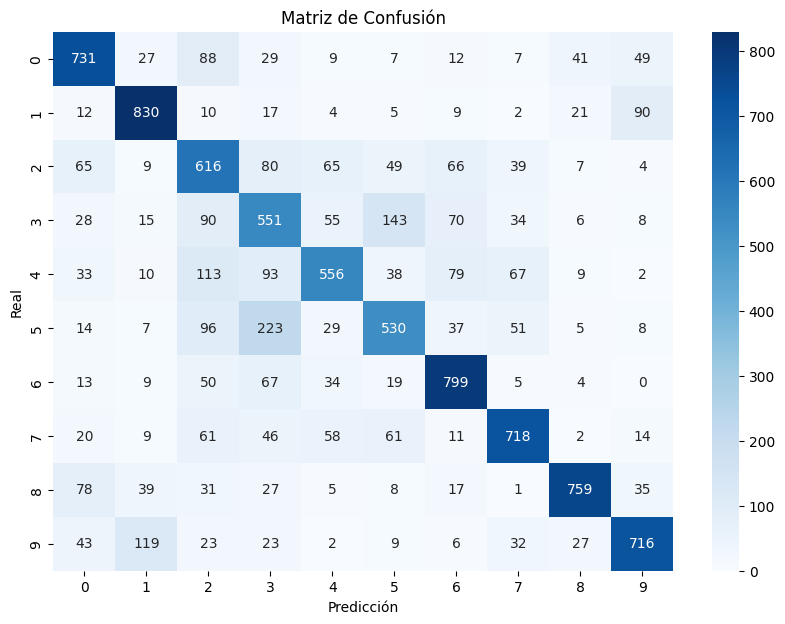

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1000
           1       0.77      0.83      0.80      1000
           2       0.52      0.62      0.57      1000
           3       0.48      0.55      0.51      1000
           4       0.68      0.56      0.61      1000
           5       0.61      0.53      0.57      1000
           6       0.72      0.80      0.76      1000
           7       0.75      0.72      0.73      1000
           8       0.86      0.76      0.81      1000
           9       0.77      0.72      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [15]:
# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)  # Predicciones en formato de clase
y_test_labels = np.argmax(y_test, axis=1)  # Etiquetas reales en formato de clase

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))

In [16]:
# Definir modelo CNN con 2 capas convolucionales
model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(32,32,3)),
    Conv2D(64, (3,3), activation="relu", padding="same"),
    Conv2D(128, (3,3), activation="relu", padding="same"),
    Conv2D(256, (3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")  # 10 clases de CIFAR-10
])

# Compilar modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

# Evaluar modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en test: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.3463 - loss: 1.7804 - val_accuracy: 0.5698 - val_loss: 1.2041
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.6281 - loss: 1.0450 - val_accuracy: 0.6585 - val_loss: 0.9759
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7302 - loss: 0.7708 - val_accuracy: 0.6988 - val_loss: 0.8542
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7952 - loss: 0.5911 - val_accuracy: 0.7091 - val_loss: 0.8691
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8539 - loss: 0.4232 - val_accuracy: 0.7050 - val_loss: 0.9686
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9018 - loss: 0.2866 - val_accuracy: 0.7087 - val_loss: 1.0758
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9383 - loss: 0.1824 - val_accuracy: 0.7017 - val_loss: 1.1814
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9564 - loss: 0.1269 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


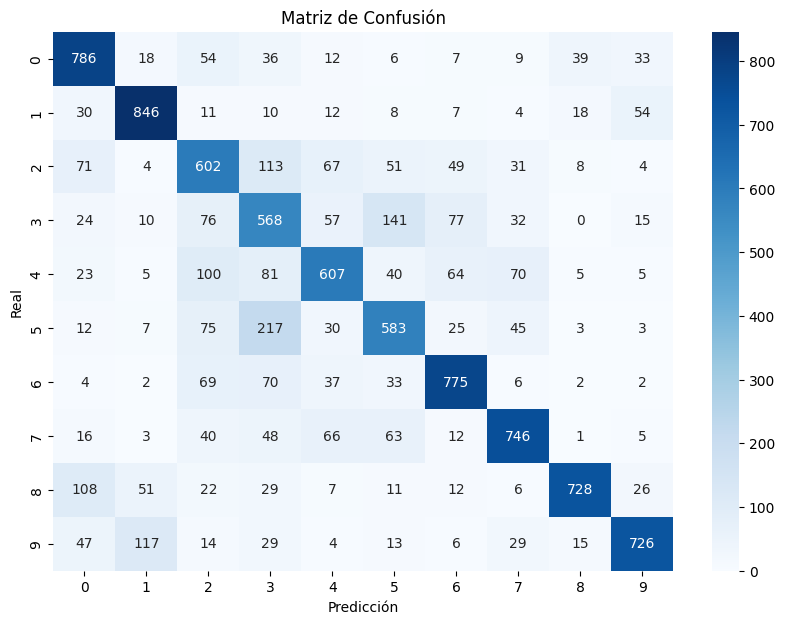

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1000
           1       0.80      0.85      0.82      1000
           2       0.57      0.60      0.58      1000
           3       0.47      0.57      0.52      1000
           4       0.68      0.61      0.64      1000
           5       0.61      0.58      0.60      1000
           6       0.75      0.78      0.76      1000
           7       0.76      0.75      0.75      1000
           8       0.89      0.73      0.80      1000
           9       0.83      0.73      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



In [17]:
# Predicciones
y_pred = model.predict(x_test)

# Convertir las predicciones y las etiquetas de one-hot a clases
y_pred = np.argmax(y_pred, axis=1)  # Predicciones en formato de clase
y_test_labels = np.argmax(y_test, axis=1)  # Etiquetas reales en formato de clase

# Mostrar la matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred)

# Crear un gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(map(str, range(10))), yticklabels=list(map(str, range(10))))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test_labels, y_pred))